In [1]:
import pandas as pd
import numpy as np
import math as m
import matplotlib.pyplot as plt
from scipy.special import gammaln, digamma, polygamma, betaln
import scipy
import scipy.stats as st
from scipy.stats import kurtosis, skew
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

Hier krijg ik een groot dataset met alle kernels

In [2]:
def ObtainAllKernels():
    Kernel=pd.read_csv("Kernel2007.csv",usecols=['DATE','Kernel'], index_col=['DATE'])
    years=['2008','2009','2010','2011','2012','2013','2014']
    for year in years:
        file=pd.read_csv("Kernel"+year+'.csv',usecols=['DATE','Kernel'],index_col=['DATE'])
        Kernel=pd.concat([Kernel,file])
    return Kernel

Hier lees ik ook de log-returns in en definieer ik de hoe lang de insample dataset is. In ons geval gebruiken we de eerste 5 jaar.

In [3]:
Kernel=ObtainAllKernels()
Returns=pd.read_csv("DailyReturns.csv",usecols=['DATE',"LogReturns"], index_col=['DATE'])
InSampleReturns=Returns['LogReturns'].loc[:"2012"]
OutSampleReturns=Returns['LogReturns'].loc["2012":]
Log_InSampleKernel=Kernel['Kernel'].loc[:'2012'].apply(np.log)
LogKernel=Kernel['Kernel'].apply(np.log)
OutKernel=Kernel['Kernel'].loc['2012':]


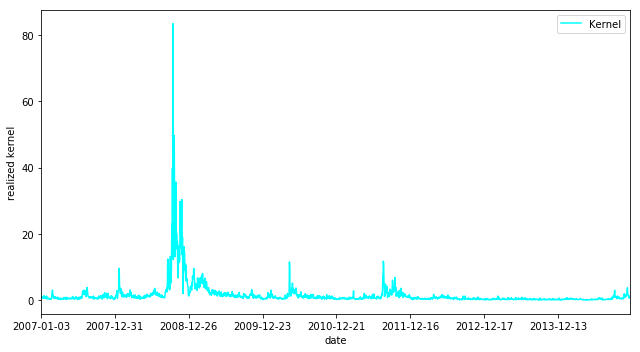

In [4]:
Kernel['Kernel'].plot(figsize=(9, 5),label='Kernel',color='aqua')
plt.legend()
plt.ylabel("realized kernel")
plt.xlabel("date")
plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)
plt.savefig('Kernel.png')
plt.show()

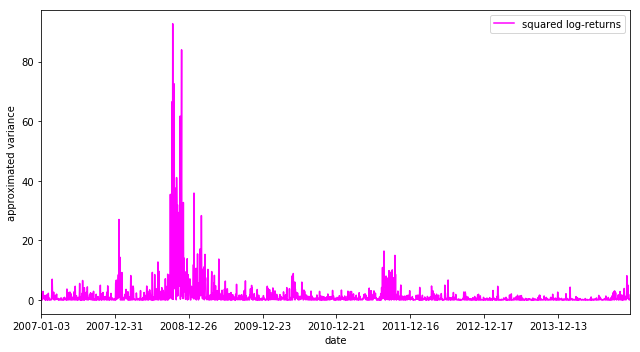

In [5]:
Returns['LogReturns'].pow(2).plot(figsize=(9, 5), color='magenta', label='squared log-returns')
plt.legend()
plt.ylabel("approximated variance")
plt.xlabel("date")
plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)
plt.savefig('SquaredReturns.png')
plt.show()

## Realized GARCH Normal
Hier definieer ik de log-likelihood met normaal verdeling. In deze functie:
- Initialiseer ik de parameters en bepaal ik de bounds van de parameters
- definieer ik de log-likelihood in de functie Log_likelihood_GARCH_Normal
- optimaliseer ik de log-likelihood met de functie Optimizer met slsqp

In [6]:
def Parameter_GARCH_Normal(returns,log_kernel):
    omega_ini=0.1
    beta_ini=0.8
    gamma_ini=0.3
    xi_ini=1
    phi_ini=1
    tau_1_ini=1
    tau_2_ini=1
    sig_u_ini=1
    
    theta=np.array([omega_ini,beta_ini,gamma_ini,xi_ini,phi_ini,tau_1_ini,tau_2_ini,sig_u_ini])
    def Log_likelihood_GARCH_NORMAL(theta,returns,log_kernel):
        T=len(returns)
        T1=len(log_kernel)
        omega=theta[0]
        beta=theta[1]
        gamma=theta[2]
        xi=theta[3]
        phi=theta[4]
        tau_1=theta[5]
        tau_2=theta[6]
        sig_u=theta[7]
        
        log_sigma=np.zeros(T)
        log_sigma[0]=np.log(np.var(returns))
        
        for i in range(0,T-1):
            log_sigma[i+1]= omega + beta* log_sigma[i] + gamma*log_kernel[i]
        
        u_t=np.zeros(T1)
        
        for t in range(T1):
            u_t[t]= log_kernel[t] - xi - phi * log_sigma[t] - tau_1 * (returns[t]/np.sqrt(np.exp(log_sigma[t]))) - tau_2 * ((returns[t]**2/np.exp(log_sigma[t]))-1)
        
        l = -1/2 * np.log(2 * np.pi) -1/2*log_sigma - 1/2*(returns**2/np.exp(log_sigma))  \
        -1/2 * np.log(2 * np.pi * sig_u**2) - 1/2 * u_t**2/sig_u**2
        
        return -np.sum(l)
    
    def Optimizer(returns, log_kernel, initials, function, bnds):
        result = minimize(function, initials, args=(returns,log_kernel), \
                          options ={'eps':1e-09, 'disp': True, 'maxiter':200}, method='SLSQP',bounds=bnds)
        return result
    bounds = ((-m.inf, m.inf), (0, 10), (0, 10), (-m.inf, m.inf), (0, 10), (-m.inf, m.inf), (-m.inf, m.inf), (0.00001, 100))
    result=Optimizer(returns, log_kernel, theta, Log_likelihood_GARCH_NORMAL,bounds)
    return result.x, -result.fun, result.success

Hier krijg ik de resultaten van mijn optimimalisatie te zien. De volgorde van de parameter set output is als volgt:
                                                 [$\omega,\beta,\gamma,\xi,\phi,\tau_1,\tau_2,\sigma_u$] Hierbij is $\sigma_u$ de standaard deviatie

In [7]:
(parameter_N,likelihood_N,success_N)=Parameter_GARCH_Normal(np.array(InSampleReturns),np.array(Log_InSampleKernel))
print(parameter_N)
print("log-likelihood= ",likelihood_N)
print(success_N)

C:\Users\Adib\anaconda\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in exp
C:\Users\Adib\anaconda\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in exp
C:\Users\Adib\anaconda\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Adib\anaconda\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Adib\anaconda\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Adib\anaconda\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Adib\anaconda\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in square


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2454.382451688144
            Iterations: 49
            Function evaluations: 534
            Gradient evaluations: 49
[-0.00156497  0.46519694  0.50939264  0.01986523  0.99227066 -0.07736377
  0.0865323   0.37128406]
log-likelihood=  -2454.382451688144
True


## Realized GARCH Student t
Hier definieer ik de log-likelihood met student t verdeling. In deze functie:
- Initialiseer ik de parameters en bepaal ik de bounds van de parameters
- definieer ik de log-likelihood in de functie Log_likelihood_GARCH_Student
- optimaliseer ik de log-likelihood met de functie Optimizer met slsqp

In [8]:
def Parameter_GARCH_Student(returns,log_kernel):
    omega_ini=0.1
    beta_ini=0.8
    gamma_ini=0.3
    xi_ini=1
    phi_ini=1
    tau_1_ini=1
    tau_2_ini=1
    nu1_ini=6
    nu2_ini=6
    sig_u_ini=1
    
    theta=np.array([omega_ini, beta_ini, gamma_ini, xi_ini, phi_ini, tau_1_ini, tau_2_ini, nu1_ini, nu2_ini, sig_u_ini])
    def Log_likelihood_GARCH_Student(theta,returns,log_kernel):
        T=len(returns)
        T1=len(log_kernel)
        omega=theta[0]
        beta=theta[1]
        gamma=theta[2]
        xi=theta[3]
        phi=theta[4]
        tau_1=theta[5]
        tau_2=theta[6]
        nu1=theta[7]
        nu2=theta[8]
        sig_u=theta[9]
        
        log_sigma=np.zeros(T)
        log_sigma[0]=np.log(np.var(returns))
        
        for i in range(0,T-1):
            log_sigma[i+1]= omega + beta* log_sigma[i] + gamma*log_kernel[i]
        
        u_t=np.zeros(T1)
        
        for t in range(T1):
            u_t[t]= log_kernel[t] - xi - phi * log_sigma[t] - tau_1 * (returns[t]/np.sqrt(np.exp(log_sigma[t]))) - tau_2 * ((returns[t]**2/np.exp(log_sigma[t]))-1)
        
        l = gammaln( (nu1+1)/2 ) - gammaln( nu1/2 ) - 1/2*np.log( (nu1-2)*np.pi*np.exp(log_sigma) ) - 1/2*(nu1+1)*np.log( 1 +  (returns**2)/((nu1-2)*np.exp(log_sigma)) ) \
            + gammaln( (nu2+1)/2 ) - gammaln( nu2/2 ) - 1/2*np.log( (nu2-2)*np.pi*sig_u**2 ) - 1/2*(nu2+1)*np.log( 1 +  (u_t**2)/((nu2-2)*sig_u**2) ) 
        
        return -np.sum(l)
    
    def Optimizer(returns, log_kernel, initials, function, bnds):
        result = minimize(function, initials, args=(returns,log_kernel), \
                          options ={'eps':1e-09, 'disp': True, 'maxiter':200}, method='SLSQP',bounds=bnds)
        return result
    bounds = ((-m.inf, m.inf), (0, 10), (0, 10), (-m.inf, m.inf), (0, 10), (-m.inf, m.inf), (-m.inf, m.inf), (2.1, 50), (2.1, 30), (0.00001, 100))
    result=Optimizer(returns, log_kernel, theta, Log_likelihood_GARCH_Student, bounds)
    return result.x, -result.fun, result.success

Hier krijg ik weer de parameters van de log likelihood met Student-t verdeling. De volgorde van de parameter estimate output is: [$\omega, \beta, \gamma, \xi, \phi, \tau_1, \tau_2, \nu_1, \nu_2 , \sigma_u $]. $\sigma_u$ is hier weer de standaard deviatie van $u_t$ en $\nu_i$ is het aantal vrijheidsgraden

In [9]:
(parameter_St,likelihood_St,success_St)=Parameter_GARCH_Student(np.array(InSampleReturns),np.array(Log_InSampleKernel))
print(parameter_St)
print("log-likelihood= ",likelihood_St)
print(success_St)

C:\Users\Adib\anaconda\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Adib\anaconda\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Adib\anaconda\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log
C:\Users\Adib\anaconda\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Adib\anaconda\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Adib\anaconda\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in subtract
C:\Users\Adib\anaconda\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Adib\anaconda\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in true_divide
C:\Users\Adib\ana

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2434.831550005441
            Iterations: 61
            Function evaluations: 787
            Gradient evaluations: 61
[ -5.38186542e-03   4.87059507e-01   4.91655677e-01   2.01372308e-02
   9.91858126e-01  -8.05215218e-02   8.24111557e-02   4.75454506e+01
   7.65186470e+00   3.72035436e-01]
log-likelihood=  -2434.831550005441
True


## Realized GARCH  Skewed Student-t
Hier definieer ik de log-likelihood met skewed student t verdeling. In deze functie:
- Initialiseer ik de parameters en bepaal ik de bounds van de parameters
- definieer ik de log-likelihood in de functie Log_likelihood_GARCH_Skew
- optimaliseer ik de log-likelihood met de functie Optimizer met slsqp

In [10]:
def Parameter_GARCH_Skew(returns,log_kernel):
    omega_ini=0.1
    beta_ini=0.8
    gamma_ini=0.3
    xi_ini=1
    phi_ini=1
    tau_1_ini=1
    tau_2_ini=1
    sig_u_ini=1
    nu1_ini=6
    nu2_ini=6
    Asym1=1
    Asym2=1
    
    theta=np.array([omega_ini, beta_ini, gamma_ini, xi_ini, phi_ini, tau_1_ini, tau_2_ini, sig_u_ini, nu1_ini, nu2_ini, Asym1, Asym2])
    def Log_likelihood_GARCH_Skew(theta,returns,log_kernel):
        T=len(returns)
        T1=len(log_kernel)
        omega=theta[0]
        beta=theta[1]
        gamma=theta[2]
        xi=theta[3]
        phi=theta[4]
        tau_1=theta[5]
        tau_2=theta[6]
        sig_u=theta[7]
        nu1=theta[8]
        nu2=theta[9]
        Asym1=theta[10]
        Asym2=theta[11]
        
        log_sigma=np.zeros(T)
        log_sigma[0]=np.log(np.var(returns))
        
        for i in range(0,T-1):
            log_sigma[i+1]= omega + beta* log_sigma[i] + gamma*log_kernel[i]
        
        u_t=np.zeros(T1)
        
        for t in range(T1):
            u_t[t]= log_kernel[t] - xi - phi * log_sigma[t] - tau_1 * (returns[t]/np.sqrt(np.exp(log_sigma[t]))) - tau_2 * ((returns[t]**2/np.exp(log_sigma[t]))-1)
        
        m1=scipy.special.gamma((nu1-1)/2)/(scipy.special.gamma(nu1/2))*np.sqrt((nu1-2)/np.pi)*(Asym1-1/Asym1)
        m2=scipy.special.gamma((nu2-1)/2)/(scipy.special.gamma(nu2/2))*np.sqrt((nu2-2)/np.pi)*(Asym2-1/Asym2)
        s1=np.sqrt((Asym1**2+(1/Asym1**2)-1)-m1**2)
        s2=np.sqrt((Asym2**2+(1/Asym2**2)-1)-m2**2)
        I1 = (s1 * (returns/np.sqrt(np.exp(log_sigma)))) + m1
        I2 = (s2 * (u_t/sig_u)) + m2
        for i in range(len(I1)):
            if I1[i]<0:
                I1[i]=-1
            else:
                I1[i]=1
                
            if I2[i]<0:
                I2[i]=-1
            else:
                I2[i]=1
           
        l1 = gammaln( (nu1+1)/2 ) - gammaln( nu1/2 ) - 1/2*np.log( ( nu1-2 ) *np.pi ) -1/2 * log_sigma \
              + np.log( s1 ) + np.log( 2 / ( Asym1+1/Asym1 ) ) - ( ( nu1+1 )/2 )*np.log( 1 + ( (s1 * ( ( returns/np.sqrt( np.exp( log_sigma ) ) ) ) + m1)**2/(nu1-2))*Asym1**(-2*I1)) 
        
        l2 = gammaln( (nu2+1)/2 ) - gammaln( nu2/2 ) - 1/2*np.log( ( nu2-2 ) *np.pi * sig_u**2) \
              + np.log(s2) + np.log( 2 / ( Asym2+1/Asym2 ) ) - ( ( nu2+1 )/2 )*np.log( 1 + ( (s2 * ( ( u_t / sig_u ) ) + m2)**2/(nu2-2))*Asym2**(-2*I2))
        
        l=l1+l2
        return -np.sum(l)
    
    def Optimizer(returns, log_kernel, initials, function, bnds):
        result = minimize(function, initials, args=(returns,log_kernel), \
                          options ={'eps':1e-09, 'disp': True, 'maxiter':200}, method='SLSQP',bounds=bnds)
        return result
    bounds = ((-m.inf, m.inf), (0, 10), (0, 10), (-m.inf, m.inf), (0, 10), (-m.inf, m.inf), (-m.inf, m.inf), (0.00001, 50), (2.1, 50), (2.1,50), (0.00001, 100),(0.00001, 100))
    result=Optimizer(returns, log_kernel, theta, Log_likelihood_GARCH_Skew, bounds)
    return result.x, -result.fun, result.success

Hier krijg ik weer de parameters van de log likelihood met Skewed Student t verdeling. De volgorde van de parameter estimate output is: [$\omega, \beta, \gamma,\xi,\phi, \tau_1, \tau_2, \sigma_u,\nu_1,\nu_2, Asym_1,Asym_2$]. Hier is Asym de $\xi$ van de Skewed Student-t verdeling die de skewness bepaalt. Aangezien er al een $\xi$ in de measurement equation staat heb ik de laatste 2 even anders genoemd om verwarring te voorkomen. De $\nu_i$ is weer het aantal vrijheidsgraden.

In [11]:
(parameter_Sk,likelihood_Sk,success_Sk)=Parameter_GARCH_Skew(np.array(InSampleReturns),np.array(Log_InSampleKernel))
print(parameter_Sk)
print("log-likelihood= ",likelihood_Sk)
print(success_Sk)

C:\Users\Adib\anaconda\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Adib\anaconda\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Adib\anaconda\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Adib\anaconda\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Adib\anaconda\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Adib\anaconda\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Adib\anaconda\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Adib\anaconda\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: overflow encountered in square
C:\Users\Ad

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2422.6932204516293
            Iterations: 54
            Function evaluations: 809
            Gradient evaluations: 54
[  7.82570094e-03   4.93902281e-01   4.85433268e-01   3.70474803e-03
   9.90019817e-01  -8.42869206e-02   8.40041932e-02   3.72455493e-01
   2.63097938e+01   7.56639993e+00   8.32398996e-01   1.09551515e+00]
log-likelihood=  -2422.6932204516293
True


## Realized GARCH EGB2
Hier definieer ik de log-likelihood met EGB2 verdeling. In deze functie:

- Initialiseer ik de parameters en bepaal ik de bounds van de parameters
- definieer ik de log-likelihood in de functie Log_likelihood_GARCH_EGB2
- optimiliseer ik de log-likelihood met de functie Optimizer met slsqp

In [12]:
def Parameter_GARCH_EGB2(returns,log_kernel):
    omega_ini=0.1
    beta_ini=0.8
    gamma_ini=0.3
    xi_ini=1
    phi_ini=1
    tau_1_ini=1
    tau_2_ini=1
    p1=1
    q1=1
    p2=1
    q2=1
    sig_u_ini=1
    
    theta=np.array([omega_ini, beta_ini, gamma_ini, xi_ini, phi_ini, tau_1_ini, tau_2_ini, p1, q1, p2, q2, sig_u_ini])
    def Log_likelihood_GARCH_EGB2(theta,returns,log_kernel):
        T=len(returns)
        T1=len(log_kernel)
        omega=theta[0]
        beta=theta[1]
        gamma=theta[2]
        xi=theta[3]
        phi=theta[4]
        tau_1=theta[5]
        tau_2=theta[6]
        p1=theta[7]
        q1=theta[8]
        p2=theta[9]
        q2=theta[10]
        sig_u=theta[11]
        
        log_sigma=np.zeros(T)
        log_sigma[0]=np.log(np.var(returns))
        
        delta1=digamma(p1)-digamma(q1)
        omega1=polygamma(1,p1)+polygamma(1,q1)
        
        delta2=digamma(p2)-digamma(q2)
        omega2=polygamma(1,p2)+polygamma(1,q2)
        
        for i in range(0,T-1):
            log_sigma[i+1]= omega + beta* log_sigma[i] + gamma*log_kernel[i]
        
        u_t=np.zeros(T1)
        
        for t in range(T1):
            u_t[t]= log_kernel[t] - xi - phi * log_sigma[t] - tau_1 * (returns[t]/np.sqrt(np.exp(log_sigma[t]))) -\
            tau_2 * ((returns[t]**2/np.exp(log_sigma[t]))-1)
        
        l1 = 1/2 * np.log(omega1) +\
        p1*( np.sqrt( omega1 ) * returns / np.sqrt( np.exp( log_sigma ) ) + delta1) - 1/2*log_sigma - betaln(p1,q1) - \
        (p1+q1) *np.log(1 +np.exp( np.sqrt( omega1 ) * returns / ( np.sqrt( np.exp( log_sigma ) ) ) + delta1 ) ) 
        
        l2 = 1/2 * np.log(omega2) + p2*( np.sqrt( omega2 ) * u_t / sig_u + delta2 ) -1/2*np.log(sig_u**2) \
            -betaln(p2,q2) - (p2+q2) * np.log(1 + np.exp( np.sqrt( omega2 ) * u_t / sig_u + delta2 ) )
        
        l= l1 + l2
        
        return -np.sum(l)
    
    def Optimizer(returns, log_kernel, initials, function, bnds):
        result = minimize(function, initials, args=(returns,log_kernel), \
                          options ={'eps':1e-09, 'disp': True, 'maxiter':200}, method='SLSQP',bounds=bnds)
        return result
    bounds = ((-m.inf, m.inf), (0, 1), (0, 10), (-m.inf, m.inf), (0, 1), (-m.inf, m.inf), (-m.inf, m.inf), (0.0001, 50), (0.0001, 50), (0.0001, 50), (0.0001, 50), (0.00001, 100))
    result=Optimizer(returns, log_kernel, theta, Log_likelihood_GARCH_EGB2, bounds)
    return result.x, -result.fun, result.success

Hier krijg ik weer de parameters van de log likelihood met egb2 verdeling. De volgorde van de parameter estimate output is: 
<br> 
[$\omega,\beta,\gamma,\xi,\phi,\tau_1, \tau_2,p_1,q_1,p_2,q_2,\sigma_u$].

In [13]:
(parameter_Eg,likelihood_Eg,success_Eg)=Parameter_GARCH_EGB2(np.array(InSampleReturns),np.array(Log_InSampleKernel))
print(parameter_Eg)
print("log-likelihood= ",likelihood_Eg)
print(success_Eg)

C:\Users\Adib\anaconda\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Adib\anaconda\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Adib\anaconda\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Adib\anaconda\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Adib\anaconda\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in subtract
C:\Users\Adib\anaconda\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in exp
C:\Users\Adib\anaconda\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Adib\anaconda\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: overflow encountered in exp


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2424.478678498618
            Iterations: 63
            Function evaluations: 930
            Gradient evaluations: 63
[  1.15807562e-02   4.91109515e-01   4.87035336e-01  -3.95579194e-03
   9.91897094e-01  -8.45635592e-02   8.51112954e-02   2.36577482e+00
   5.32463530e+00   1.12477364e+00   9.03626799e-01   3.71374125e-01]
log-likelihood=  -2424.478678498618
True


In [14]:
def kurtosisAndSkewness(vTheta,returns,log_kernel,distribution):
    T=len(returns)
    T1=len(log_kernel)
    omega=vTheta[0]
    beta=vTheta[1]
    gamma=vTheta[2]
    xi=vTheta[3]
    phi=vTheta[4]
    tau_1=vTheta[5]
    tau_2=vTheta[6]
    if distribution=='normal':
        sig_u=vTheta[7]
    elif distribution=='student' or distribution=='skewed':
        sig_u=vTheta[7]
    else:
        sig_u=vTheta[11]
        
    log_sigma=np.zeros(T)
    log_sigma[0]=np.log(np.var(returns))  
    u_t=np.zeros(T1)
    
    for i in range(0,T-1):
        log_sigma[i+1]= omega + beta* log_sigma[i] + gamma*log_kernel[i]
   
    for t in range(T1):
        u_t[t]= log_kernel[t] - xi - phi * log_sigma[t] - tau_1 * (returns[t]/np.sqrt(np.exp(log_sigma[t]))) -\
        tau_2 * ((returns[t]**2/np.exp(log_sigma[t]))-1)   
        
    std_residuals=returns/np.sqrt(np.exp(log_sigma))
    std_u=u_t/sig_u
    print("kurtosis of standardized residuals = ", kurtosis(std_residuals)+3, " skewness of standardized residuals = ", skew(std_residuals))
    print("kurtosis of standardized u_t = ", kurtosis(std_u)+3, " skewness u_t = ", skew(std_u))
    

#### Hier bereken ik de kurtosis en skewness van de standardized residuen en de standardized $u_t$. Dit doe ik voor elk realized garch model

In [15]:
print("normal realized garch")
kurtosisAndSkewness(parameter_N,InSampleReturns,Log_InSampleKernel,'normal')
print("\n")
print("student t realized garch")
kurtosisAndSkewness(parameter_St,InSampleReturns,Log_InSampleKernel,'student')
print("\n")
print("skewed student t realized garch")
kurtosisAndSkewness(parameter_Sk,InSampleReturns,Log_InSampleKernel,'skewed')
print("\n")
print("egb2 realized garch")
kurtosisAndSkewness(parameter_Eg,InSampleReturns,Log_InSampleKernel,'egb2')

normal realized garch
kurtosis of standardized residuals =  3.197278173008272  skewness of standardized residuals =  -0.27689047266072353
kurtosis of standardized u_t =  4.2309169689013215  skewness u_t =  0.14103764957210663


student t realized garch
kurtosis of standardized residuals =  3.2003296502958962  skewness of standardized residuals =  -0.2763969625824911
kurtosis of standardized u_t =  4.270364688368929  skewness u_t =  0.13844414325758772


skewed student t realized garch
kurtosis of standardized residuals =  3.200932863225101  skewness of standardized residuals =  -0.2762528654397256
kurtosis of standardized u_t =  4.27202113799122  skewness u_t =  0.1448953616282131


egb2 realized garch
kurtosis of standardized residuals =  3.1999562973679874  skewness of standardized residuals =  -0.27629888079433046
kurtosis of standardized u_t =  4.26622533180881  skewness u_t =  0.1452575176788432


Hier vindt de forecast van de sigma plaats, waarmee ik de parameters van de realized garch mee geef. Ik return uiteindelijk de outsample $\sigma^2_t$

In [16]:
def forecast(vTheta,returnsIn,returnsOut,log_kernel):
    vFullReturns=np.concatenate((returnsIn,returnsOut))
    T=len(returnsIn)
    T1=len(log_kernel)
    omega=vTheta[0]
    beta=vTheta[1]
    gamma=vTheta[2]
    log_sigma=np.zeros(len(returnsIn)+len(returnsOut))
    log_sigma[0]=np.log(np.var(returnsIn))
    for i in range(0,len(vFullReturns)-1):
        log_sigma[i+1]= omega + beta* log_sigma[i] + gamma*log_kernel[i]
        
    sigma2=np.exp(log_sigma[len(returnsIn):])
    return sigma2    

#### Hier bereken ik de prediction errors

In [17]:
def PredictionError(vTheta,returnsIn, returnsOut,log_kernel,OutSampleKernel):
    sigma2=forecast(vTheta,returnsIn, returnsOut,log_kernel)
    v2=OutSampleKernel
    
    forecastMeasurement=np.zeros(5)
    forecastMeasurement[0] = np.mean((v2-sigma2)**2)#mse(v2,sigma2)
    forecastMeasurement[1] = np.median((v2-sigma2)**2)
    forecastMeasurement[2] = mae(v2,sigma2)
    forecastMeasurement[3] = np.mean(abs(v2-sigma2)/abs(v2+sigma2))
    
    dTIC_Num=np.sqrt(np.mean((v2-sigma2)**2))
    dTIC_Den1=np.sqrt(np.mean(v2**2))
    dTIC_Den2=np.sqrt(np.mean(sigma2**2))
    forecastMeasurement[4] = dTIC_Num/(dTIC_Den1+dTIC_Den2)
    print(forecastMeasurement)

#### volgorde van de prediction error output: [mean squared error, Median squared error, mean absolute error, AMAPE, TIC]

In [18]:
print("prediction error realized garch normal:")
PredictionError(parameter_N,np.array(InSampleReturns),np.array(OutSampleReturns),np.array(LogKernel),np.array(OutKernel))
print("\n")
print("prediction error realized garch student t:")
PredictionError(parameter_St,np.array(InSampleReturns),np.array(OutSampleReturns),np.array(LogKernel),np.array(OutKernel))
print("\n")
print("prediction error realized garch skewed student t")
PredictionError(parameter_Sk,np.array(InSampleReturns),np.array(OutSampleReturns),np.array(LogKernel),np.array(OutKernel))
print("\n")
print("prediction error realized garch EGB2")
PredictionError(parameter_Eg,np.array(InSampleReturns),np.array(OutSampleReturns),np.array(LogKernel),np.array(OutKernel))

prediction error realized garch normal:
[ 0.05350124  0.00802027  0.14212109  0.15611029  0.20761066]


prediction error realized garch student t:
[ 0.05367962  0.00759221  0.14114023  0.15511067  0.2092172 ]


prediction error realized garch skewed student t
[ 0.05382813  0.00827961  0.14337085  0.1567228   0.20704315]


prediction error realized garch EGB2
[ 0.05389642  0.00866512  0.14424759  0.15749262  0.20634574]


Berkenen van de AIC

In [19]:
def AIC(log_likelihood,vTheta):
    aic=2*len(vTheta)-2*log_likelihood
    print("AIC= ",aic)

In [20]:
print("realized garch normal")
AIC(likelihood_N,parameter_N)
print("\n")
print("realized garch student t")
AIC(likelihood_St,parameter_St)
print("\n")
print("realized garch skewed student t")
AIC(likelihood_Sk, parameter_Sk)
print("\n")
print("realized garch egb2")
AIC(likelihood_Eg, parameter_Eg)

realized garch normal
AIC=  4924.764903376288


realized garch student t
AIC=  4889.663100010882


realized garch skewed student t
AIC=  4869.3864409032585


realized garch egb2
AIC=  4872.957356997236


# Backtesten van de VaR 

Kansverdeling van de EGB2 

In [21]:
def EGB2(datapunt, sigma, p, q):
    omega = scipy.special.polygamma(1,p)+scipy.special.polygamma(1,q)
    delta = scipy.special.digamma(p)-scipy.special.digamma(q)
    noemer = np.sqrt(omega)*np.exp(p*(np.sqrt(omega)*(datapunt/sigma)+delta))
    b=scipy.special.gamma(p)*scipy.special.gamma(q)/scipy.special.gamma(p+q)
    deler = sigma*b*(1+np.exp(np.sqrt(omega)*(datapunt/sigma)+delta))**(p+q)
    return noemer/deler

Hier wordt een kwantiel verkregen van de EGB2 verdeling voor een percentage van $\alpha$ %

In [22]:
def egb2_kwantiel(p, q, alpha):
    grid_randpunten = np.arange(-20,20,0.001)
    grid_midpunten = np.arange(-20+(0.001/2), 20-(0.001/2), 0.001)
    cum_vector = np.zeros(len(grid_randpunten))
    i=0
    while(cum_vector[i]<=alpha):
        i+=1
        cum_vector[i]=0.001*EGB2(grid_midpunten[i-1], 1, p, q)+cum_vector[i-1]
    
    return grid_randpunten[i]

kansverdeling van de skewed student t. 

In [23]:
def skewed_t(datapunt, sigma, dof, xi):
    a = scipy.special.gamma((dof+1)/2)
    b=scipy.special.gamma(dof/2)
    c=np.sqrt((dof-2)*np.pi*sigma**2)
    m=scipy.special.gamma((dof-1)/2)/scipy.special.gamma(dof/2)*np.sqrt((dof-2)/np.pi)*(xi-1/xi)
    s=np.sqrt(xi**2+1/(xi**2)-1-m**2)
    d=2/(xi+1/xi)
    I=0
    if(s*datapunt/sigma+m>=0):
        I=1
    else:
        I=-1
    e=(1+(s*(datapunt/sigma)+m)**2/(dof-2)*xi**(-2*I))**(-1*(dof+1)/2)
    return(a/b/c*s*d*e)

Hier wordt een kwantiel verkregen van de skewed student t model voor een percentage van $\alpha$ %

In [24]:
def skewedt_kwantiel(dof, xi, alpha):
    grid_randpunten = np.arange(-20,20,0.001)
    grid_midpunten = np.arange(-20+(0.001/2), 20-(0.001/2), 0.001)
    cum_vector = np.zeros(len(grid_randpunten))
    i=0
    while(cum_vector[i]<=alpha):
        i+=1
        cum_vector[i]=0.001*skewed_t(grid_midpunten[i-1], 1, dof, xi)+cum_vector[i-1]
    
    return grid_randpunten[i] 

Hier wordt de VaR berekend voor een bepaalde waarde voor $\alpha$. Eerst wordt de kwantielen verkregen voor de verdelingen die worden gebruikt. Daarna bereken ik de $VaR_t$= $Z_{\alpha}$ $\times$ $\sigma_t$, waarbij $Z_{\alpha}$ een kwantiel van een bepaalde verdeling.

In [25]:
def VaR(vTheta,returnsIn,returnsOut,log_kernel,distribution):
    sigma2=forecast(vTheta,returnsIn, returnsOut,log_kernel)
    if distribution=='normal':
        (quantile1,quantile5)=(st.norm.ppf(0.01),st.norm.ppf(0.05))
    elif distribution=='student':
        quantile1 = np.sqrt((vTheta[7]-2)/vTheta[7])*st.t.ppf(0.01,vTheta[7]),
        quantile5 = np.sqrt((vTheta[7]-2)/vTheta[7])*st.t.ppf(0.05,vTheta[7])
    elif distribution=='skewed':
        quantile1=skewedt_kwantiel(vTheta[8], vTheta[10], 0.01)
        quantile5=skewedt_kwantiel(vTheta[8], vTheta[10], 0.05)
    else:
        quantile1=egb2_kwantiel(vTheta[7],vTheta[8],0.01)
        quantile5=egb2_kwantiel(vTheta[7],vTheta[8],0.05)
    var1=quantile1*np.sqrt(sigma2)
    var5=quantile5*np.sqrt(sigma2)
    print(quantile1,quantile5)
    return var1,var5   

In [26]:
(var1_N,var5_N)=VaR(parameter_N,np.array(InSampleReturns),np.array(OutSampleReturns),np.array(LogKernel),'normal')
(var1_St,var5_St)=VaR(parameter_St,np.array(InSampleReturns),np.array(OutSampleReturns),np.array(LogKernel),'student')
(var1_Sk,var5_Sk)=VaR(parameter_Sk,np.array(InSampleReturns),np.array(OutSampleReturns),np.array(LogKernel),'skewed')
(var1_Eg,var5_Eg)=VaR(parameter_Eg,np.array(InSampleReturns),np.array(OutSampleReturns),np.array(LogKernel),'egb2')

-2.32634787404 -1.64485362695
(-2.356196428270894,) -1.64187786672
-2.58699999998 -1.73399999998
-2.63899999998 -1.72399999998


# plot van de VaR voor verschillende verdelingen 

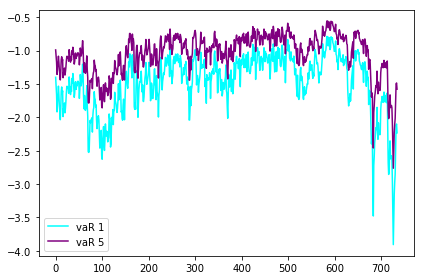

In [27]:
plt.figure(2)
plt.plot(var1_N,label='vaR 1',color='aqua')
plt.plot(var5_N,label='vaR 5',color='purple')
plt.legend()
plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)
plt.savefig('vaRNormalRGARCH.png')
plt.show()

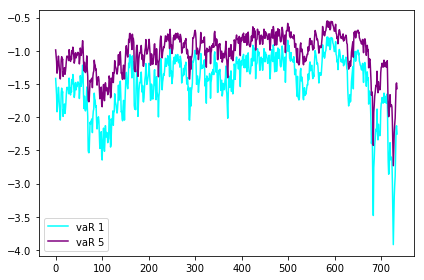

In [28]:
plt.figure(3)
plt.plot(var1_St,label='vaR 1',color='aqua')
plt.plot(var5_St,label='vaR 5',color='purple')
plt.legend()
plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)
plt.savefig('vaRStudentRGARCH.png')
plt.show()

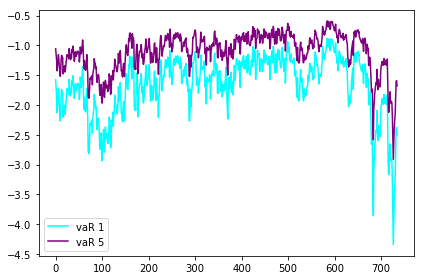

In [29]:
plt.figure(4)
plt.plot(var1_Sk,label='vaR 1',color='aqua')
plt.plot(var5_Sk,label='vaR 5',color='purple')
plt.legend()
plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)
plt.savefig('vaRSkewedRGARCH.png')
plt.show()

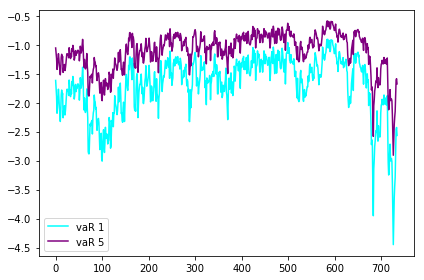

In [30]:
plt.figure(5)
plt.plot(var1_Eg,label='vaR 1',color='aqua')
plt.plot(var5_Eg,label='vaR 5',color='purple')
plt.legend()
plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)
plt.savefig('vaREGB2RGARCH.png')
plt.show()

Hier wordt de formule van de unconditional coverage toegepast. De reden dat ik I1=I1+0 is omdat I1=returnsOut < var1 een boolean terug geeft als ik plus 0 doe dan convert het naar een geheel getal. De value True geeft mij dan het getal 1 terug. Dit is handig, omdat ik dan geen for loops hoef toe te passen die veel tijd kosten. Ditzelfde geldt voor I5. Hierbij wordt de volgende formule toegepast:
<break>
$LR_{uc}=2\ln\left[p^N(1-p)^{T-N}\right]-2\ln\left[\alpha^N(1-\alpha)^{T-N}\right] \sim \chi^2(1)$
<break>
**Ga het niet handmatig overnemen. Het staat in mijn scriptie (en in die van Akram). Je kan de formule ook gwn kopieren van de deze cell als je er op klikt**

In [31]:
def LR_UNC(var1,var5,returnsOut):
    T=len(returnsOut)
    I1=returnsOut<var1
    I5=returnsOut<var5
    I1=I1+0
    I5=I5+0
    N1=np.sum(I1)
    N5=np.sum(I5)
    LR_UN1=2*(N1*np.log(N1/T)+(T-N1)*np.log(1-N1/T))-2*(N1*np.log(0.01)+(T-N1)*np.log(1-0.01))
    LR_UN5=2*(N5*np.log(N5/T)+(T-N5)*np.log(1-N5/T))-2*(N5*np.log(0.05)+(T-N5)*np.log(1-0.05))
    
    print("LR_unc for alpha=1%: ", LR_UN1, " met kwantiel voor 1%: ",st.chi2.ppf(0.99,1))
    print("LR_unc for alpha=5%: ", LR_UN5, " met kwantiel voor 5%: ",st.chi2.ppf(0.95,1),"\n")    
    return (LR_UN1,LR_UN5)

Hier worden de waarden van de unconditional coverage test uitgeprint

In [32]:
print("realized GARCH normal")
(LR_unc1_N,LR_unc5_N)=LR_UNC(var1_N,var5_N,np.array(OutSampleReturns))
print("realized GARCH student")
(LR_unc1_St,LR_unc5_St)=LR_UNC(var1_St,var5_St,np.array(OutSampleReturns))
print("realized GARCH skewed student t")
(LR_unc1_Sk,LR_unc5_Sk)=LR_UNC(var1_Sk,var5_Sk,np.array(OutSampleReturns))
print("realized GARCH EGB2")
(LR_unc1_Eg,LR_unc5_Eg)=LR_UNC(var1_Eg,var5_Eg,np.array(OutSampleReturns))

realized GARCH normal
LR_unc for alpha=1%:  6.18120669343  met kwantiel voor 1%:  6.63489660102
LR_unc for alpha=5%:  0.0442820628546  met kwantiel voor 5%:  3.84145882069 

realized GARCH student
LR_unc for alpha=1%:  4.80295685967  met kwantiel voor 1%:  6.63489660102
LR_unc for alpha=5%:  0.0442820628546  met kwantiel voor 5%:  3.84145882069 

realized GARCH skewed student t
LR_unc for alpha=1%:  0.349181081856  met kwantiel voor 1%:  6.63489660102
LR_unc for alpha=5%:  0.674491238459  met kwantiel voor 5%:  3.84145882069 

realized GARCH EGB2
LR_unc for alpha=1%:  0.0171060248107  met kwantiel voor 1%:  6.63489660102
LR_unc for alpha=5%:  0.416479840841  met kwantiel voor 5%:  3.84145882069 



Hier wordt de $LR_{ind}$ berekend. De bijbehorende formule is:
<break>
    $LR_{ind} = -2 \ln \left[\left(1-\frac{N}{T}\right)^{n_{00}+n_{10}}\left(\frac{N}{T}\right)^{n_{01}+n_{11}}\right] + 2 \ln [(1-\hat{p}_{01})^{n_{00}}\hat{p}_{01}^{n_{01}}(1-\hat{p}_{11})^{n_{10}}\hat{p}_{11}^{n_{11}}]$
<break>
waarbij:
<break>
$\hat{p}_{ij} = \frac{n_{ij}}{\sum_{j} n_{ij}}$
<break>
**Ga het niet handmatig overnemen. Het staat in mijn scriptie (en in die van Akram). Je kan de formule ook gwn kopieren van de deze cell als je er op klikt**

In [33]:
def LR_IND(var1,var5,returnsOut):
    T=len(returnsOut)
    I1=returnsOut<var1
    I5=returnsOut<var5
    I1=I1+0
    I5=I5+0    
    N1=np.sum(I1)
    N5=np.sum(I5)
    (n100,n101,n110,n111)=(0,0,0,0)
    (n500,n501,n510,n511)=(0,0,0,0)
    for i in range(len(I1)-1):
        if I1[i]==0 and I1[i+1]==0:
            n100+=1
        elif I1[i]==0 and I1[i+1]==1:
            n101+=1
        elif I1[i]==1 and I1[i+1]==0:
            n110+=1
        elif I1[i]==1 and I1[i+1]==1:
            n111+=1
            
        if I5[i]==0 and I5[i+1]==0:
            n500+=1
        elif I5[i]==0 and I5[i+1]==1:
            n501+=1
        elif I5[i]==1 and I5[i+1]==0:
            n510+=1
        elif I5[i]==1 and I5[i+1]==1:
            n511+=1            
            
    p101=n101/(n100+n101)
    p111=n111/(n110+n111)
    
    p501=n501/(n500+n501)
    p511=n511/(n510+n511)
    
    LR_Ind1=-2*((n100+n110)*np.log(1-N1/T)+(n101+n111)*np.log(N1/T))+2*(np.log((1-p101)**n100)+np.log(p101**n101)\
            +np.log((1-p111)**n110)+np.log(p111**n111))
    
    LR_Ind5=-2*((n500+n510)*np.log(1-N5/T)+(n501+n511)*np.log(N5/T))+2*(np.log((1-p501)**n500)+np.log(p501**n501)\
            +np.log((1-p511)**n510)+np.log(p511**n511))
    print("LR_ind for alpha=1%: ", LR_Ind1, " met kwantiel voor 1%: ",st.chi2.ppf(0.99,1))
    print("LR_ind for alpha=5%: ", LR_Ind5, " met kwantiel voor 5%: ",st.chi2.ppf(0.95,1),"\n")
    return (LR_Ind1,LR_Ind5)

Hier worden de $LR_{ind}$ verkregen voor verschillende verdelingen en verschillende waardes voor $\alpha$

In [34]:
print("realized GARCH normal")
(LR_ind1_N,LR_ind5_N)=LR_IND(var1_N,var5_N,np.array(OutSampleReturns))
print("realized GARCH student")
(LR_ind1_St,LR_ind5_St)=LR_IND(var1_St,var5_St,np.array(OutSampleReturns))
print("realized GARCH skewed student t")
(LR_ind1_Sk,LR_ind5_Sk)=LR_IND(var1_Sk,var5_Sk,np.array(OutSampleReturns))
print("realized GARCH EGB2")
(LR_ind1_Eg,LR_ind5_Eg)=LR_IND(var1_Eg,var5_Eg,np.array(OutSampleReturns))

realized GARCH normal
LR_ind for alpha=1%:  0.625943041578  met kwantiel voor 1%:  6.63489660102
LR_ind for alpha=5%:  4.1515635044  met kwantiel voor 5%:  3.84145882069 

realized GARCH student
LR_ind for alpha=1%:  0.54450520003  met kwantiel voor 1%:  6.63489660102
LR_ind for alpha=5%:  4.1515635044  met kwantiel voor 5%:  3.84145882069 

realized GARCH skewed student t
LR_ind for alpha=1%:  0.223470896856  met kwantiel voor 1%:  6.63489660102
LR_ind for alpha=5%:  2.91845208595  met kwantiel voor 5%:  3.84145882069 

realized GARCH EGB2
LR_ind for alpha=1%:  0.134815727271  met kwantiel voor 1%:  6.63489660102
LR_ind for alpha=5%:  3.10820262272  met kwantiel voor 5%:  3.84145882069 



Hier wordt de $LR_{cc}$ berekend. 
de formule van de $LR_{cc}=LR_{unc}+LR_{ind}$ is:
<break>
$ LR_{cc} = -2 \log \left[(1-p)^{T-N}p^N\right] + 2 \log \left[(1-\hat{p}_{01})^{n_{00}}\hat{p}_{01}^{n_{01}}(1-\hat{p}_{11})^{n_{10}}\hat{p}_{11}^{n_{11}}\right]$

In [35]:
def LR_CC(LR_unc1,LR_unc5,LR_ind1,LR_ind5):
    LR_cc1=LR_unc1+LR_ind1
    LR_cc5=LR_unc5+LR_ind5
    print("LR_cc for alpha=1%=",LR_cc1)
    print("LR_cc for alpha=5%=",LR_cc5,"\n")

In [36]:
print("results for realized GARCH normal")
LR_CC(LR_unc1_N,LR_unc5_N,LR_ind1_N,LR_ind5_N)
print("results for realized GARCH student t")
LR_CC(LR_unc1_St,LR_unc5_St,LR_ind1_St,LR_ind5_St)
print("results for realized GARCH skewed student t")
LR_CC(LR_unc1_Sk,LR_unc5_Sk,LR_ind1_Sk,LR_ind5_Sk)
print("results for realized GARCH EGB2")
LR_CC(LR_unc1_Eg,LR_unc5_Eg,LR_ind1_Eg,LR_ind5_Eg)
print("kwantiel voor alpha=1%: ",st.chi2.ppf(0.99,2),"kwantiel voor alpha=5%: ",st.chi2.ppf(0.95,2))

results for realized GARCH normal
LR_cc for alpha=1%= 6.807149735
LR_cc for alpha=5%= 4.19584556725 

results for realized GARCH student t
LR_cc for alpha=1%= 5.3474620597
LR_cc for alpha=5%= 4.19584556725 

results for realized GARCH skewed student t
LR_cc for alpha=1%= 0.572651978712
LR_cc for alpha=5%= 3.59294332441 

results for realized GARCH EGB2
LR_cc for alpha=1%= 0.151921752082
LR_cc for alpha=5%= 3.52468246356 

kwantiel voor alpha=1%:  9.21034037198 kwantiel voor alpha=5%:  5.99146454711


# Hier wordt de score van de verschillende verdelingen berekend

In [37]:
def LogLikelihoodNormal(theta,returns,log_sigma,u_t):
    omega=theta[0]
    beta=theta[1]
    gamma=theta[2]
    xi=theta[3]
    phi=theta[4]
    tau_1=theta[5]
    tau_2=theta[6]
    sig_u=theta[7]
    l = -1/2 * np.log(2 * np.pi) -1/2*log_sigma - 1/2*(returns**2/np.exp(log_sigma))  #\
    #    -1/2 * np.log(2 * np.pi * sig_u**2) - 1/2 * u_t**2/sig_u**2   
    return l    

In [38]:
def LogLikelihoodStudent(theta,returns,log_sigma,u_t):
    omega=theta[0]
    beta=theta[1]
    gamma=theta[2]
    xi=theta[3]
    phi=theta[4]
    tau_1=theta[5]
    tau_2=theta[6]
    nu1=theta[7]
    nu2=theta[8]
    sig_u=theta[9]
    
    l=gammaln( (nu1+1)/2 ) - gammaln( nu1/2 ) - 1/2*np.log( (nu1-2)*np.pi*np.exp(log_sigma) ) - 1/2*(nu1+1)*np.log( 1 +  (returns**2)/((nu1-2)*np.exp(log_sigma))) #\
        #+ gammaln( (nu2+1)/2 ) - gammaln( nu2/2 ) - 1/2*np.log( (nu2-2)*np.pi*sig_u**2 ) - 1/2*(nu2+1)*np.log( 1 +  (u_t**2)/((nu2-2)*sig_u**2) )

    return l

In [39]:
def LogLikelihoodSkewed(theta,returns,log_sigma,u_t):
    omega=theta[0]
    beta=theta[1]
    gamma=theta[2]
    xi=theta[3]
    phi=theta[4]
    tau_1=theta[5]
    tau_2=theta[6]
    sig_u=theta[7]
    nu1=theta[8]
    nu2=theta[9]
    Asym1=theta[10]
    Asym2=theta[11]
    m1=scipy.special.gamma((nu1-1)/2)/(scipy.special.gamma(nu1/2))*np.sqrt((nu1-2)/np.pi)*(Asym1-1/Asym1)
    m2=scipy.special.gamma((nu2-1)/2)/(scipy.special.gamma(nu2/2))*np.sqrt((nu2-2)/np.pi)*(Asym2-1/Asym2)
    s1=np.sqrt((Asym1**2+(1/Asym1**2)-1)-m1**2)
    s2=np.sqrt((Asym2**2+(1/Asym2**2)-1)-m2**2)
    I1 = (s1 * (returns/np.sqrt(np.exp(log_sigma)))) + m1
    I2 = (s2 * (u_t/sig_u)) + m2    
    for i in range(len(I1)):
        if I1[i]<0:
            I1[i]=-1
        else:
            I1[i]=1
                
        if I2[i]<0:
            I2[i]=-1
        else:
            I2[i]=1    
    l1 = gammaln( (nu1+1)/2 ) - gammaln( nu1/2 ) - 1/2*np.log( ( nu1-2 ) *np.pi ) -1/2 * log_sigma \
          + np.log( s1 ) + np.log( 2 / ( Asym1+1/Asym1 ) ) - ( ( nu1+1 )/2 )*np.log( 1 + ( (s1 * ( ( returns/np.sqrt( np.exp( log_sigma ) ) ) ) + m1)**2/(nu1-2))*Asym1**(-2*I1)) 
        
    l2 = gammaln( (nu2+1)/2 ) - gammaln( nu2/2 ) - 1/2*np.log( ( nu2-2 ) *np.pi * sig_u**2) \
          + np.log(s2) + np.log( 2 / ( Asym2+1/Asym2 ) ) - ( ( nu2+1 )/2 )*np.log( 1 + ( (s2 * ( ( u_t / sig_u ) ) + m2)**2/(nu2-2))*Asym2**(-2*I2))
    l=l1#+l2

    
    return l

In [40]:
def LogLikelihoodEGB2(theta,returns,log_sigma,u_t):
    omega=theta[0]
    beta=theta[1]
    gamma=theta[2]
    xi=theta[3]
    phi=theta[4]
    tau_1=theta[5]
    tau_2=theta[6]
    p1=theta[7]
    q1=theta[8]
    p2=theta[9]
    q2=theta[10]
    sig_u=theta[11]
    
    delta1=digamma(p1)-digamma(q1)
    omega1=polygamma(1,p1)+polygamma(1,q1)
    delta2=digamma(p2)-digamma(q2)
    omega2=polygamma(1,p2)+polygamma(1,q2)
    
    l1 = 1/2 * np.log(omega1) +\
        p1*( np.sqrt( omega1 ) * returns / np.sqrt( np.exp( log_sigma ) ) + delta1) - 1/2*log_sigma - betaln(p1,q1) - \
        (p1+q1) *np.log(1 +np.exp( np.sqrt( omega1 ) * returns / ( np.sqrt( np.exp( log_sigma ) ) ) + delta1 ) ) 
        
    l2 = 1/2 * np.log(omega2) + p2*( np.sqrt( omega2 ) * u_t / sig_u + delta2 ) -1/2*np.log(sig_u**2) \
            -betaln(p2,q2) - (p2+q2) * np.log(1 + np.exp( np.sqrt( omega2 ) * u_t / sig_u + delta2 ) )
    l=l1#+l2
    
    return l


# Log-Score
Hier wordt afhankelijk van de van de verdeling die als input wordt meegeven de logarithmic score berekend. Dit wordt als een vector gelaten, omdat deze vectoren uiteindelijk ons de dibold mariano test statistic gaan geven zodat we verschillende waardes met elkaar kunnen vergelijken 

In [41]:
def Logarithmic_score(theta,returnsIn, returnsOut,log_kernel,OutSampleKernel,distribution):
    omega=theta[0]
    beta=theta[1]
    gamma=theta[2]
    xi=theta[3]
    phi=theta[4]
    tau_1=theta[5]
    tau_2=theta[6]    
    sigma2=forecast(theta,returnsIn, returnsOut,log_kernel)
    log_sigma=np.log(sigma2)
    log_kernel_out=np.log(OutSampleKernel)
    T=len(returnsOut)
    u_t=np.zeros(T)
    for t in range(T):
        u_t[t]= log_kernel_out[t] - xi - phi * log_sigma[t] - tau_1 * (returnsOut[t]/np.sqrt(np.exp(log_sigma[t]))) - tau_2 * ((returnsOut[t]**2/np.exp(log_sigma[t]))-1)   
    if distribution=='normal':
        l=LogLikelihoodNormal(theta,returnsOut,log_sigma,u_t)
    elif distribution=='student':
        l=LogLikelihoodStudent(theta,returnsOut,log_sigma,u_t)
    elif distribution=='skewed':
        l=LogLikelihoodSkewed(theta,returnsOut,log_sigma,u_t)
    else:
        l=LogLikelihoodEGB2(theta,returnsOut,log_sigma,u_t)
    
    
    print("score "+distribution +": ",np.sum(l))
    return l
    


Hier worden de vectoren van de score van elk model verkregen. Om de score te krijgen moet de som van deze vectoren worden genomen. 

In [42]:
l_score_N=Logarithmic_score(parameter_N,np.array(InSampleReturns),np.array(OutSampleReturns),np.array(LogKernel),OutKernel,'normal')
l_score_St=Logarithmic_score(parameter_St,np.array(InSampleReturns),np.array(OutSampleReturns),np.array(LogKernel),OutKernel,'student')
l_score_Sk=Logarithmic_score(parameter_Sk,np.array(InSampleReturns),np.array(OutSampleReturns),np.array(LogKernel),OutKernel,'skewed')
l_score_Eg=Logarithmic_score(parameter_Eg,np.array(InSampleReturns),np.array(OutSampleReturns),np.array(LogKernel),OutKernel,'EGB2')

score normal:  -674.778861656
score student:  -672.895532773
score skewed:  -670.603178728
score EGB2:  -669.288944166


Hier wordt een export van de vectoren gemaakt naar een csv file

In [43]:
np.savetxt("NormalRGARCH.csv", l_score_N, delimiter=",")
np.savetxt("StudentRGARCH.csv", l_score_St, delimiter=",")
np.savetxt("SkewedRGARCH.csv", l_score_Sk, delimiter=",")
np.savetxt("EGB2RGARCH.csv", l_score_Eg, delimiter=",")

Dit is de functie om de diebold mariano test statistic te berekenen.

In [44]:
def DieboldMariano(l_score1,l_score2):
    d=l_score1-l_score2
    d_bar=np.mean(d)
    sigma_d=np.std(d)
    t=len(d)*d_bar/sigma_d
    print(t)

In [45]:
DieboldMariano(l_score_N,l_score_St)
DieboldMariano(l_score_N,l_score_Sk)
DieboldMariano(l_score_N,l_score_Eg)
DieboldMariano(l_score_St,l_score_Sk)
DieboldMariano(l_score_St,l_score_Eg)
DieboldMariano(l_score_Sk,l_score_Eg)

-67.0488838436
-28.5211807785
-37.1001693684
-16.8794200157
-26.7752838306
-44.4584321494
